## Lab06
110065508 李丞恩

1. Loading of dataset
2. Splitting of dataset to training and testing data (test_size = 20% of the whole dataset)
3. Building of a self-designed Logistic Regression model (Complete the TODO parts provided below)
4. Plotting of the confusion matrix. (Label 0 as positive)
5. Computing the F1-score of this confusion matrix. The F1-score should be at least 0.75

先說結論：我真的不知道怎麼樣用到0.75QQQ

In [1]:
# inline plotting instead of popping out
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
plt = matplotlib.pyplot

import os
import numpy as np
import pandas as pd

from IPython.display import Image
from IPython.display import display

from numpy.linalg import norm
from scipy import interp
from sklearn.linear_model import LinearRegression
from sklearn.metrics import auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from cycler import cycler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from lib import *
if not os.path.exists("output_HW/") : os.mkdir("output_HW/")

## Loading of dataset

In [2]:
#load the data
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                   'arrhythmia/arrhythmia.data', header=None, sep=',', engine='python')

display(data.head(3))

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


How big is the dataset?

In [3]:
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 280 columns


The last column of the dataset is the class label. It contains the 16 ECG classifications:

In [4]:
np.unique(data[len(data.columns)-1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16], dtype=int64)

Let's make that column (class label) dichotomous.
Value is 0 if ECG is normal, 1 otherwise

In [5]:
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)
data = data.drop(len(data.columns)-2, axis=1)

Are the groups balanced?

In [6]:
data.groupby(['arrhythmia']).size()

arrhythmia
0    245
1    207
dtype: int64

Some columns have missing values denoted as '?'
To make the preprocessing simpler, let's just retain the columns with numeric values.

In [7]:
data = data._get_numeric_data()
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 275 columns


In [8]:
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,1
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,1
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,1


In [9]:
X = data.iloc[:, :-1]  # The first to second-last columns are the features
y = data.iloc[:, -1]   # The last column is the ground-truth label
print(np.unique(y))
print(X.shape)

[0 1]
(452, 274)


In [10]:
# splitting the dataset to training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20211018)

In [11]:
# Standardizing the training and test datasets
# Note that we are scaling based on the information from the training data
# Then we apply the scaling that is done from training data to the test data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## Building of a self-designed Logistic Regression model 

cost function: $\log P(\mathbf{y}|\mathbf{x};\mathbf{w})=\mathbf{y}\cdot\sigma(\mathbf{w^⊤x})+(1−\mathbf{y})\cdot[1−\sigma(\mathbf{w^⊤x})]-\alpha||\mathbf{w}||$

以下的code有部分參考大三修機器學習導論(電機系)時的作業與上課講義

In [12]:
class LogisticRegression(object):

    def __init__(self, eta=0.05, n_epoch=100, random_state=1, alpha=0):
        self.eta = eta
        self.n_epoch = n_epoch
        self.random_state = random_state
        self.alpha = alpha #不想處理0的問題所以用alpha
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_epoch):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = self.loss(output, y)-self.alpha*norm(self.w_)**2
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def loss(self, output, y): # TODO
        """Calculate loss"""
        return -y.dot(np.log(output))-((1-y).dot(np.log(1-output)))
    
    def activation(self, z): # TODO
        """Compute logistic sigmoid activation"""
        # To avoid the error message "RuntimeWarning: overflow encountered", use np.clip
        return 1. / (1. + np.exp(-np.clip(z, -20, 20))) # boundary=20 is enough

    def predict(self, X): # TODO
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.5, 1, 0) 
        # The logistic function takes real number values as input and transforms 
        # them to values in the range [0,1] with an intercept at σ(z)=0.5 .

## Model training

首先，我先用Lab3的方法找出最重要的特徵

In [13]:
# Train a RandomForestClassifier as model 
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.80


繪圖來看看特徵經過排序後重要性分布的情形。由圖，我選擇0.001作為threshold，未超過之的特徵予以捨棄。

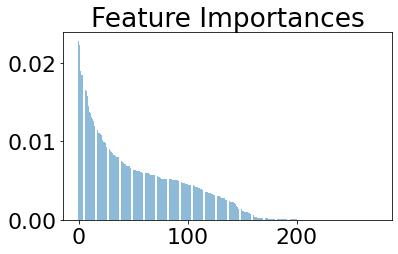

In [14]:
importances = forest.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center',
        alpha=0.5)

plt.tight_layout()
plt.savefig('./output_HW/fig-forest-feature-importances.png', dpi=300)
plt.show()

捨棄不要的特徵。

In [15]:
from sklearn.feature_selection import SelectFromModel
feat_labels = data.columns[:278]
sfm = SelectFromModel(forest, threshold=0.001, prefit=True) #根據上個block計算，重要度超過門檻值才選入模型中
X_selected = sfm.transform(X_train_std) # new X_train
X_selected_test = sfm.transform(X_test_std) # new X_test

然後手刻一個GridSearch，因為我們是土炮的邏輯斯回歸，沒辦法用scikit-learn提供的pipeline class。

In [16]:
pairs = []
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] 
param_range2 = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] 
for alpha in param_range:
    for eta in param_range2:
        X_train2, X_val, y_train2, y_val = train_test_split(X_selected, y_train, test_size=0.2, random_state=42)
        lr = LogisticRegression(eta=eta, n_epoch=300, random_state=0, alpha=alpha)
        lr.fit(X_train2, y_train2)
        y_pred = lr.predict(X_val)
        pairs.append((f1_score(y_true=y_val, y_pred=y_pred), (eta, alpha)))

列出表現最好的模型參數。

In [17]:
sorted(pairs)[::-1][:10]

[(0.6538461538461537, (0.0001, 1000.0)),
 (0.6538461538461537, (0.0001, 100.0)),
 (0.6538461538461537, (0.0001, 10.0)),
 (0.6538461538461537, (0.0001, 1.0)),
 (0.6538461538461537, (0.0001, 0.1)),
 (0.6538461538461537, (0.0001, 0.01)),
 (0.6538461538461537, (0.0001, 0.001)),
 (0.6538461538461537, (0.0001, 0.0001)),
 (0.6268656716417911, (100.0, 1000.0)),
 (0.6268656716417911, (100.0, 100.0))]

可見$\alpha$值對模型的表現沒有甚麼影響。就選一個順眼的數字。

In [18]:
lr = LogisticRegression(eta=0.0001, n_epoch=1000, random_state=1, alpha=1)
lr.fit(X_selected, y_train)
y_pred = lr.predict(X_selected_test)

## Plotting of the confusion matrix.

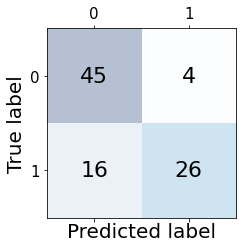

In [19]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('./output/fig-logistic-regression-confusion-2.png', dpi=300)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()

## Computing the F1-score

In [20]:
print('F1-score: %.2f' % f1_score(y_true=y_test, y_pred=y_pred))

F1-score: 0.72
